NOTEBOOK 04: CLUSTERING ANALYSIS

Mục tiêu: Phân cụm dữ liệu với K-Means, GMM và phân tích quan hệ với target

1.Import Libraries và Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import json
import joblib

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

# Load normalized data
df = pd.read_csv('../data/processed/data_normalized.csv')
print(f"✓ Data loaded: {df.shape}")

# Load metadata
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

target_col = metadata['target_column']
print(f"✓ Target variable: {target_col}")

# Separate features and target
y = df[target_col].values
X = df.drop(target_col, axis=1).values

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Load PCA-transformed data for visualization
df_pca_2d = pd.read_csv('../data/processed/pca_2D.csv')
X_pca_2d = df_pca_2d[['PC1', 'PC2']].values

✓ Libraries imported successfully!
✓ Data loaded: (1470, 48)
✓ Target variable: JobSatisfaction

Features shape: (1470, 47)
Target shape: (1470,)


2.Elbow Method for K-Means

Computing metrics for K = 2 to 10...
  K = 2... Done (Silhouette: 0.111)
  K = 3... Done (Silhouette: 0.095)
  K = 4... Done (Silhouette: 0.084)
  K = 5... Done (Silhouette: 0.098)
  K = 6... Done (Silhouette: 0.091)
  K = 7... Done (Silhouette: 0.098)
  K = 8... Done (Silhouette: 0.108)
  K = 9... Done (Silhouette: 0.099)
  K = 10... Done (Silhouette: 0.092)


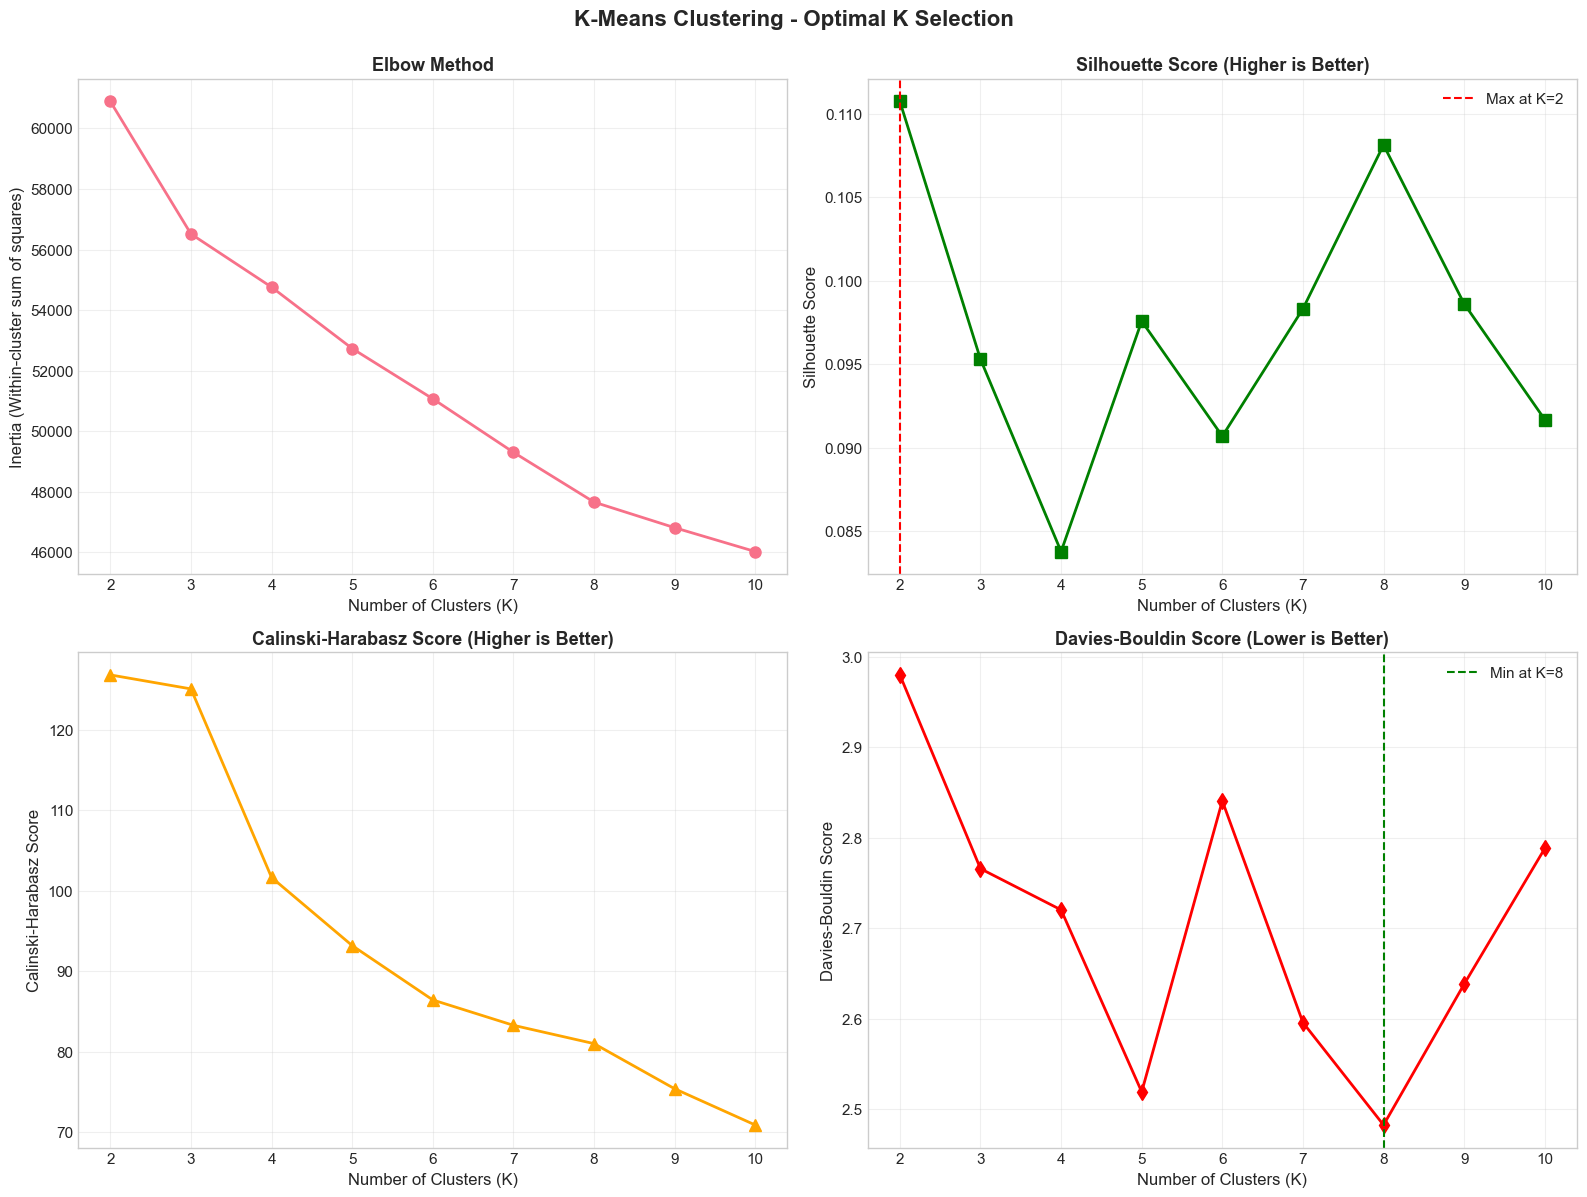


OPTIMAL K SUMMARY
 K      Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
 2 60891.228222    0.110721         126.781430        2.980263
 3 56515.500410    0.095287         125.043668        2.765987
 4 54759.945012    0.083773         101.642546        2.720423
 5 52732.313719    0.097570          93.191959        2.519203
 6 51071.892903    0.090681          86.444216        2.841005
 7 49306.171043    0.098310          83.297625        2.595869
 8 47660.723648    0.108118          81.023055        2.482574
 9 46815.598101    0.098609          75.422408        2.638325
10 46026.761673    0.091679          70.924747        2.788317

Recommended K:
  Based on Silhouette Score: K = 2
  Based on Davies-Bouldin: K = 8
  Suggested K for analysis: 4 (good balance)


In [4]:
# Test different K values
K_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Computing metrics for K = 2 to 10...")
for k in K_range:
    print(f"  K = {k}...", end='')

    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Compute metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    calinski_scores.append(calinski_harabasz_score(X, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X, labels))

    print(f" Done (Silhouette: {silhouette_scores[-1]:.3f})")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Elbow plot (Inertia)
axes[0, 0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(K_range)

# 2. Silhouette Score
axes[0, 1].plot(K_range, silhouette_scores, marker='s', linewidth=2,
                markersize=8, color='green')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(K_range)
# Mark maximum
max_idx = np.argmax(silhouette_scores)
axes[0, 1].axvline(x=K_range[max_idx], color='red', linestyle='--',
                   label=f'Max at K={K_range[max_idx]}')
axes[0, 1].legend()

# 3. Calinski-Harabasz Score
axes[1, 0].plot(K_range, calinski_scores, marker='^', linewidth=2,
                markersize=8, color='orange')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)',
                      fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(K_range)

# 4. Davies-Bouldin Score
axes[1, 1].plot(K_range, davies_bouldin_scores, marker='d', linewidth=2,
                markersize=8, color='red')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)',
                      fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(K_range)
# Mark minimum
min_idx = np.argmin(davies_bouldin_scores)
axes[1, 1].axvline(x=K_range[min_idx], color='green', linestyle='--',
                   label=f'Min at K={K_range[min_idx]}')
axes[1, 1].legend()

plt.suptitle('K-Means Clustering - Optimal K Selection',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/clustering/kmeans_optimal_k.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("OPTIMAL K SUMMARY")
print("="*70)
metrics_summary = pd.DataFrame({
    'K': list(K_range),
    'Inertia': inertias,
    'Silhouette': silhouette_scores,
    'Calinski-Harabasz': calinski_scores,
    'Davies-Bouldin': davies_bouldin_scores
})
print(metrics_summary.to_string(index=False))

# Recommend optimal K
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_davies = K_range[np.argmin(davies_bouldin_scores)]

print(f"\nRecommended K:")
print(f"  Based on Silhouette Score: K = {optimal_k_silhouette}")
print(f"  Based on Davies-Bouldin: K = {optimal_k_davies}")
print(f"  Suggested K for analysis: 4 (good balance)")

optimal_k = 4  # Choose based on analysis


3.K-Means Clustering with Optimal K

In [5]:
# Fit K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X)

# Compute metrics
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_davies = davies_bouldin_score(X, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X, kmeans_labels)

print(f"\nK-Means Metrics:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_davies:.4f}")
print(f"  Calinski-Harabasz Score: {kmeans_calinski:.4f}")
print(f"  Inertia: {kmeans.inertia_:.4f}")

# Cluster sizes
unique, counts = np.unique(kmeans_labels, return_counts=True)
print(f"\nCluster Sizes:")
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({100*count/len(kmeans_labels):.1f}%)")

# Save model
joblib.dump(kmeans, '../results/models/kmeans_model.pkl')
print("\n✓ K-Means model saved!")


K-Means Metrics:
  Silhouette Score: 0.1023
  Davies-Bouldin Index: 2.4398
  Calinski-Harabasz Score: 104.5407
  Inertia: 54492.4115

Cluster Sizes:
  Cluster 0: 83 samples (5.6%)
  Cluster 1: 819 samples (55.7%)
  Cluster 2: 318 samples (21.6%)
  Cluster 3: 250 samples (17.0%)

✓ K-Means model saved!


4.K-Means Visualization

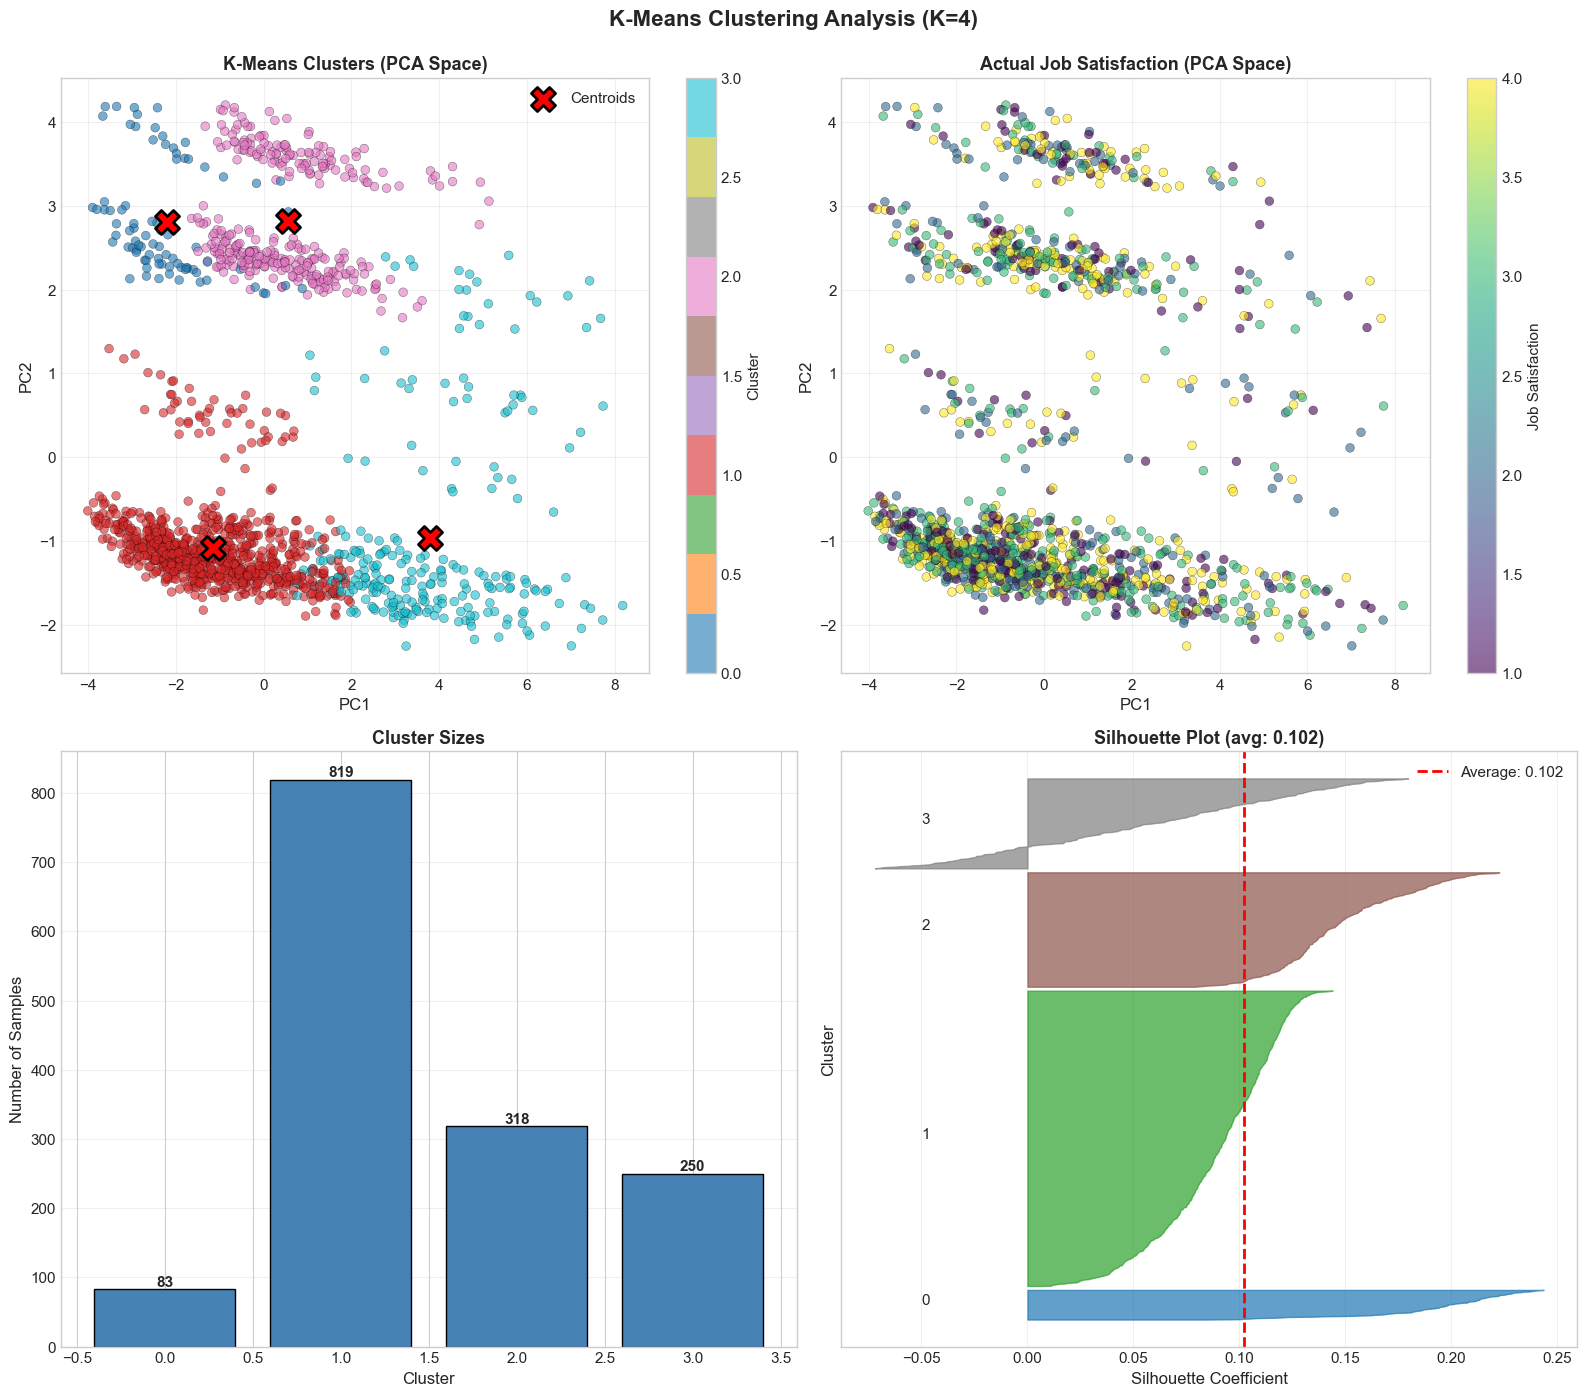

✓ K-Means visualization saved!


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Clusters on PCA space
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=kmeans_labels, cmap='tab10',
                               alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
# Plot centroids
centroids_pca = kmeans.cluster_centers_
# We need to transform centroids to PCA space
pca_model = joblib.load('../results/models/pca_2D.pkl')
centroids_pca_2d = pca_model.transform(centroids_pca)
axes[0, 0].scatter(centroids_pca_2d[:, 0], centroids_pca_2d[:, 1],
                   c='red', marker='X', s=300, edgecolor='black', linewidth=2,
                   label='Centroids')
axes[0, 0].set_xlabel('PC1', fontsize=12)
axes[0, 0].set_ylabel('PC2', fontsize=12)
axes[0, 0].set_title('K-Means Clusters (PCA Space)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Cluster', fontsize=11)

# 2. Colored by target variable
scatter2 = axes[0, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=y, cmap='viridis',
                               alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
axes[0, 1].set_xlabel('PC1', fontsize=12)
axes[0, 1].set_ylabel('PC2', fontsize=12)
axes[0, 1].set_title('Actual Job Satisfaction (PCA Space)',
                      fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Job Satisfaction', fontsize=11)

# 3. Cluster sizes bar plot
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
bars = axes[1, 0].bar(cluster_counts.index, cluster_counts.values,
                      color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
axes[1, 0].set_title('Cluster Sizes', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Silhouette plot
from matplotlib import cm
silhouette_vals = silhouette_samples(X, kmeans_labels)
y_lower = 10
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.tab10(i / optimal_k)
    axes[1, 1].fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)

    axes[1, 1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1, 1].set_xlabel('Silhouette Coefficient', fontsize=12)
axes[1, 1].set_ylabel('Cluster', fontsize=12)
axes[1, 1].set_title(f'Silhouette Plot (avg: {kmeans_silhouette:.3f})',
                     fontsize=13, fontweight='bold')
axes[1, 1].axvline(x=kmeans_silhouette, color='red', linestyle='--', linewidth=2,
                   label=f'Average: {kmeans_silhouette:.3f}')
axes[1, 1].set_yticks([])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle(f'K-Means Clustering Analysis (K={optimal_k})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/clustering/kmeans_visualization.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ K-Means visualization saved!")

5.Analyze Clusters with Target Variable


Job Satisfaction Statistics by Cluster:
         count      mean       std  min  25%  50%  75%  max
Cluster                                                    
0         83.0  2.734940  1.025104  1.0  2.0  3.0  4.0  4.0
1        819.0  2.726496  1.102750  1.0  2.0  3.0  4.0  4.0
2        318.0  2.770440  1.134826  1.0  2.0  3.0  4.0  4.0
3        250.0  2.680000  1.091037  1.0  2.0  3.0  4.0  4.0

ANOVA Test:
  F-statistic: 0.3159
  P-value: 0.813925
  Result: No significant difference between clusters (p >= 0.05)


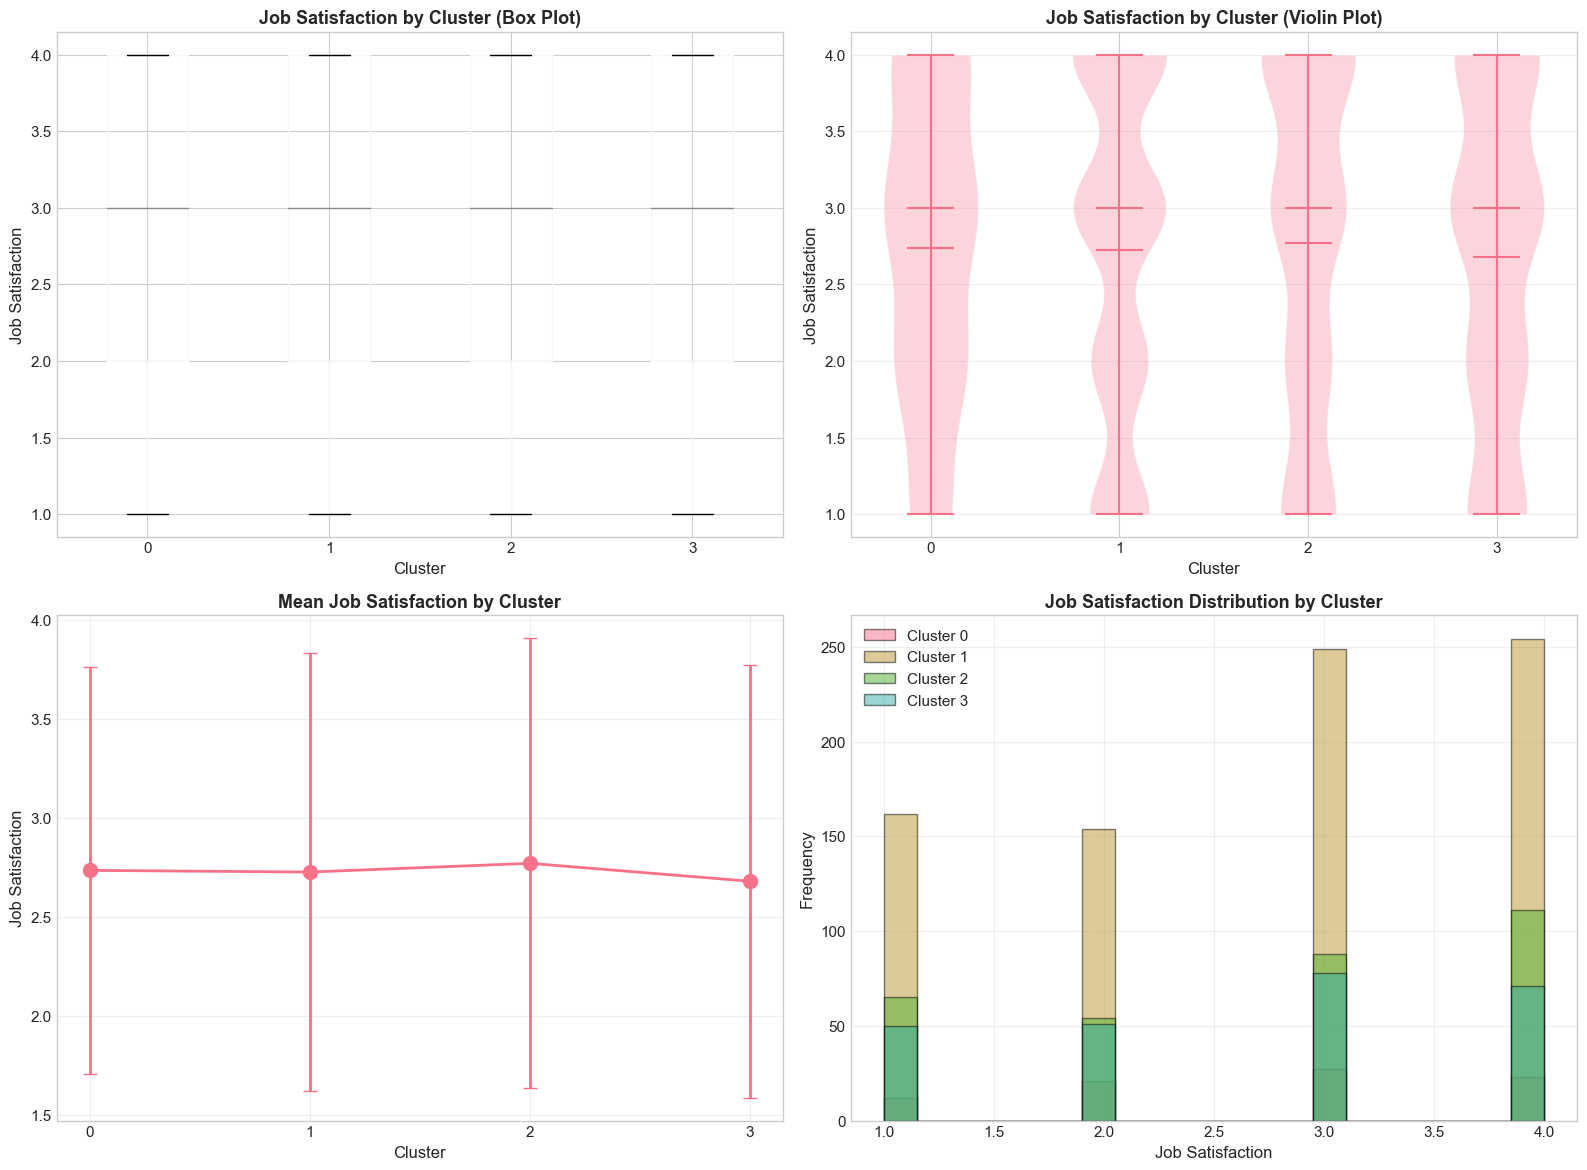


✓ Cluster-target analysis saved!


In [7]:
# Create dataframe for analysis
df_analysis = pd.DataFrame({
    'Cluster': kmeans_labels,
    'JobSatisfaction': y
})

# Descriptive statistics by cluster
cluster_stats = df_analysis.groupby('Cluster')['JobSatisfaction'].describe()
print("\nJob Satisfaction Statistics by Cluster:")
print(cluster_stats)

# Statistical tests (ANOVA)
from scipy import stats
clusters_data = [df_analysis[df_analysis['Cluster'] == i]['JobSatisfaction'].values
                 for i in range(optimal_k)]
f_stat, p_value = stats.f_oneway(*clusters_data)
print(f"\nANOVA Test:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  P-value: {p_value:.6f}")
if p_value < 0.05:
    print("  Result: Significant difference between clusters (p < 0.05)")
else:
    print("  Result: No significant difference between clusters (p >= 0.05)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot
df_analysis.boxplot(column='JobSatisfaction', by='Cluster', ax=axes[0, 0])
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Job Satisfaction', fontsize=12)
axes[0, 0].set_title('Job Satisfaction by Cluster (Box Plot)', fontsize=13, fontweight='bold')
axes[0, 0].get_figure().suptitle('')  # Remove default title

# 2. Violin plot
parts = axes[0, 1].violinplot([df_analysis[df_analysis['Cluster'] == i]['JobSatisfaction'].values
                                for i in range(optimal_k)],
                               positions=range(optimal_k),
                               showmeans=True, showmedians=True)
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Job Satisfaction', fontsize=12)
axes[0, 1].set_title('Job Satisfaction by Cluster (Violin Plot)',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(range(optimal_k))
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Mean with error bars
means = cluster_stats['mean'].values
stds = cluster_stats['std'].values
axes[1, 0].errorbar(range(optimal_k), means, yerr=stds,
                    marker='o', markersize=10, linewidth=2, capsize=5)
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Job Satisfaction', fontsize=12)
axes[1, 0].set_title('Mean Job Satisfaction by Cluster', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(optimal_k))
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution histograms
for i in range(optimal_k):
    cluster_data = df_analysis[df_analysis['Cluster'] == i]['JobSatisfaction']
    axes[1, 1].hist(cluster_data, bins=20, alpha=0.5, label=f'Cluster {i}', edgecolor='black')
axes[1, 1].set_xlabel('Job Satisfaction', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Job Satisfaction Distribution by Cluster',
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/clustering/kmeans_target_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster-target analysis saved!")

6.Gaussian Mixture Model (GMM)

Computing BIC and AIC for different components...
  K = 2: BIC = 7054.56, AIC = -5389.33
  K = 3: BIC = -21417.09, AIC = -40085.56
  K = 4: BIC = -39150.68, AIC = -64043.74
  K = 5: BIC = -38236.65, AIC = -69354.30
  K = 6: BIC = -48430.51, AIC = -85772.75
  K = 7: BIC = -48281.55, AIC = -91848.38
  K = 8: BIC = -47678.53, AIC = -97469.94
  K = 9: BIC = -43936.06, AIC = -99952.06
  K = 10: BIC = -41022.74, AIC = -103263.33


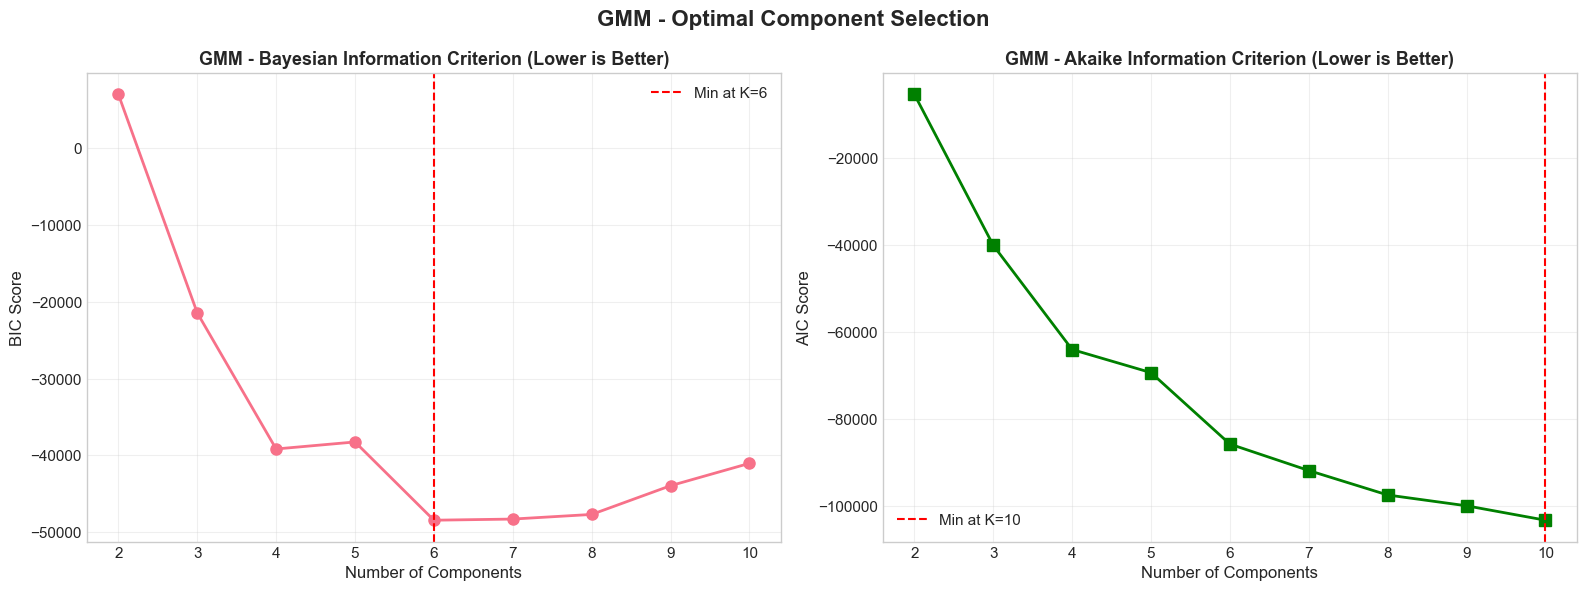


GMM Metrics (K=4):
  Silhouette Score: 0.0650
  Davies-Bouldin Index: 3.2109
  Calinski-Harabasz Score: 96.4462
  BIC: -39150.6817
  AIC: -64043.7439

GMM Cluster Sizes:
  Cluster 0: 182 samples (12.4%)
  Cluster 1: 461 samples (31.4%)
  Cluster 2: 551 samples (37.5%)
  Cluster 3: 276 samples (18.8%)

✓ GMM model saved!


In [8]:
# Test different numbers of components
gmm_bic_scores = []
gmm_aic_scores = []

print("Computing BIC and AIC for different components...")
for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X)
    gmm_bic_scores.append(gmm.bic(X))
    gmm_aic_scores.append(gmm.aic(X))
    print(f"  K = {k}: BIC = {gmm.bic(X):.2f}, AIC = {gmm.aic(X):.2f}")

# Plot BIC and AIC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(K_range, gmm_bic_scores, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('BIC Score', fontsize=12)
axes[0].set_title('GMM - Bayesian Information Criterion (Lower is Better)',
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)
min_bic_idx = np.argmin(gmm_bic_scores)
axes[0].axvline(x=K_range[min_bic_idx], color='red', linestyle='--',
                label=f'Min at K={K_range[min_bic_idx]}')
axes[0].legend()

axes[1].plot(K_range, gmm_aic_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('AIC Score', fontsize=12)
axes[1].set_title('GMM - Akaike Information Criterion (Lower is Better)',
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)
min_aic_idx = np.argmin(gmm_aic_scores)
axes[1].axvline(x=K_range[min_aic_idx], color='red', linestyle='--',
                label=f'Min at K={K_range[min_aic_idx]}')
axes[1].legend()

plt.suptitle('GMM - Optimal Component Selection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/clustering/gmm_optimal_components.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Fit GMM with optimal components
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=20)
gmm_labels = gmm.fit_predict(X)
gmm_probs = gmm.predict_proba(X)

# Compute metrics
gmm_silhouette = silhouette_score(X, gmm_labels)
gmm_davies = davies_bouldin_score(X, gmm_labels)
gmm_calinski = calinski_harabasz_score(X, gmm_labels)

print(f"\nGMM Metrics (K={optimal_k}):")
print(f"  Silhouette Score: {gmm_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {gmm_davies:.4f}")
print(f"  Calinski-Harabasz Score: {gmm_calinski:.4f}")
print(f"  BIC: {gmm.bic(X):.4f}")
print(f"  AIC: {gmm.aic(X):.4f}")

# Cluster sizes
unique_gmm, counts_gmm = np.unique(gmm_labels, return_counts=True)
print(f"\nGMM Cluster Sizes:")
for cluster, count in zip(unique_gmm, counts_gmm):
    print(f"  Cluster {cluster}: {count} samples ({100*count/len(gmm_labels):.1f}%)")

# Save model
joblib.dump(gmm, '../results/models/gmm_model.pkl')
print("\n✓ GMM model saved!")

7.GMM Visualization

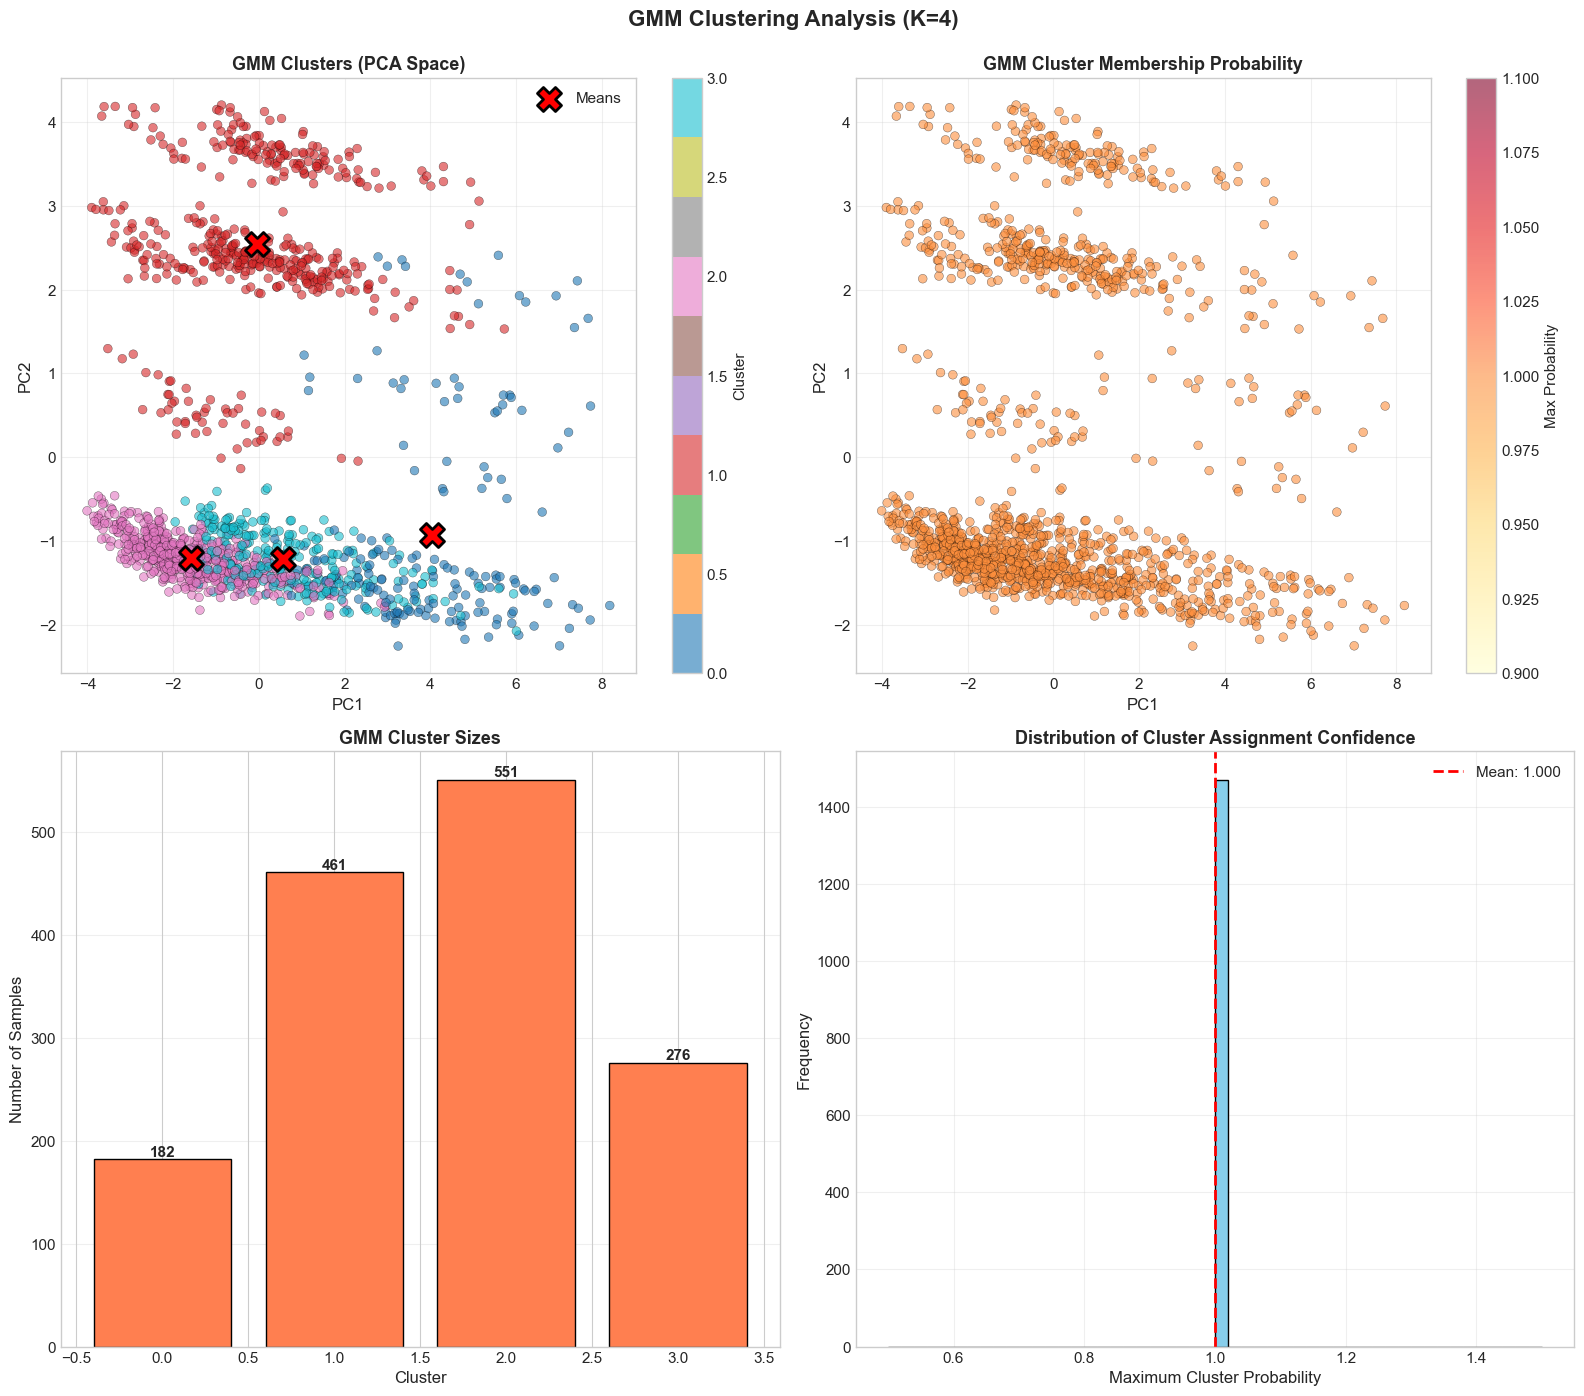

✓ GMM visualization saved!


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Clusters on PCA space
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=gmm_labels, cmap='tab10',
                               alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
# Plot means
means_pca = pca_model.transform(gmm.means_)
axes[0, 0].scatter(means_pca[:, 0], means_pca[:, 1],
                   c='red', marker='X', s=300, edgecolor='black', linewidth=2,
                   label='Means')
axes[0, 0].set_xlabel('PC1', fontsize=12)
axes[0, 0].set_ylabel('PC2', fontsize=12)
axes[0, 0].set_title('GMM Clusters (PCA Space)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Cluster', fontsize=11)

# 2. Probability of cluster membership (max probability)
max_probs = np.max(gmm_probs, axis=1)
scatter2 = axes[0, 1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=max_probs, cmap='YlOrRd',
                               alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
axes[0, 1].set_xlabel('PC1', fontsize=12)
axes[0, 1].set_ylabel('PC2', fontsize=12)
axes[0, 1].set_title('GMM Cluster Membership Probability',
                      fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Max Probability', fontsize=11)

# 3. Cluster sizes
cluster_counts_gmm = pd.Series(gmm_labels).value_counts().sort_index()
bars = axes[1, 0].bar(cluster_counts_gmm.index, cluster_counts_gmm.values,
                      color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
axes[1, 0].set_title('GMM Cluster Sizes', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Probability distribution
axes[1, 1].hist(max_probs, bins=50, edgecolor='black', color='skyblue')
axes[1, 1].set_xlabel('Maximum Cluster Probability', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Cluster Assignment Confidence',
                     fontsize=13, fontweight='bold')
axes[1, 1].axvline(x=max_probs.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {max_probs.mean():.3f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'GMM Clustering Analysis (K={optimal_k})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/clustering/gmm_visualization.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ GMM visualization saved!")

8.GMM vs Target Analysis


Job Satisfaction Statistics by GMM Cluster:
         count      mean       std  min  25%  50%  75%  max
Cluster                                                    
0        182.0  2.703297  1.102428  1.0  2.0  3.0  4.0  4.0
1        461.0  2.728850  1.112289  1.0  2.0  3.0  4.0  4.0
2        551.0  2.735027  1.109721  1.0  2.0  3.0  4.0  4.0
3        276.0  2.731884  1.078988  1.0  2.0  3.0  4.0  4.0

ANOVA Test (GMM):
  F-statistic: 0.0389
  P-value: 0.989748
  Result: No significant difference between clusters (p >= 0.05)


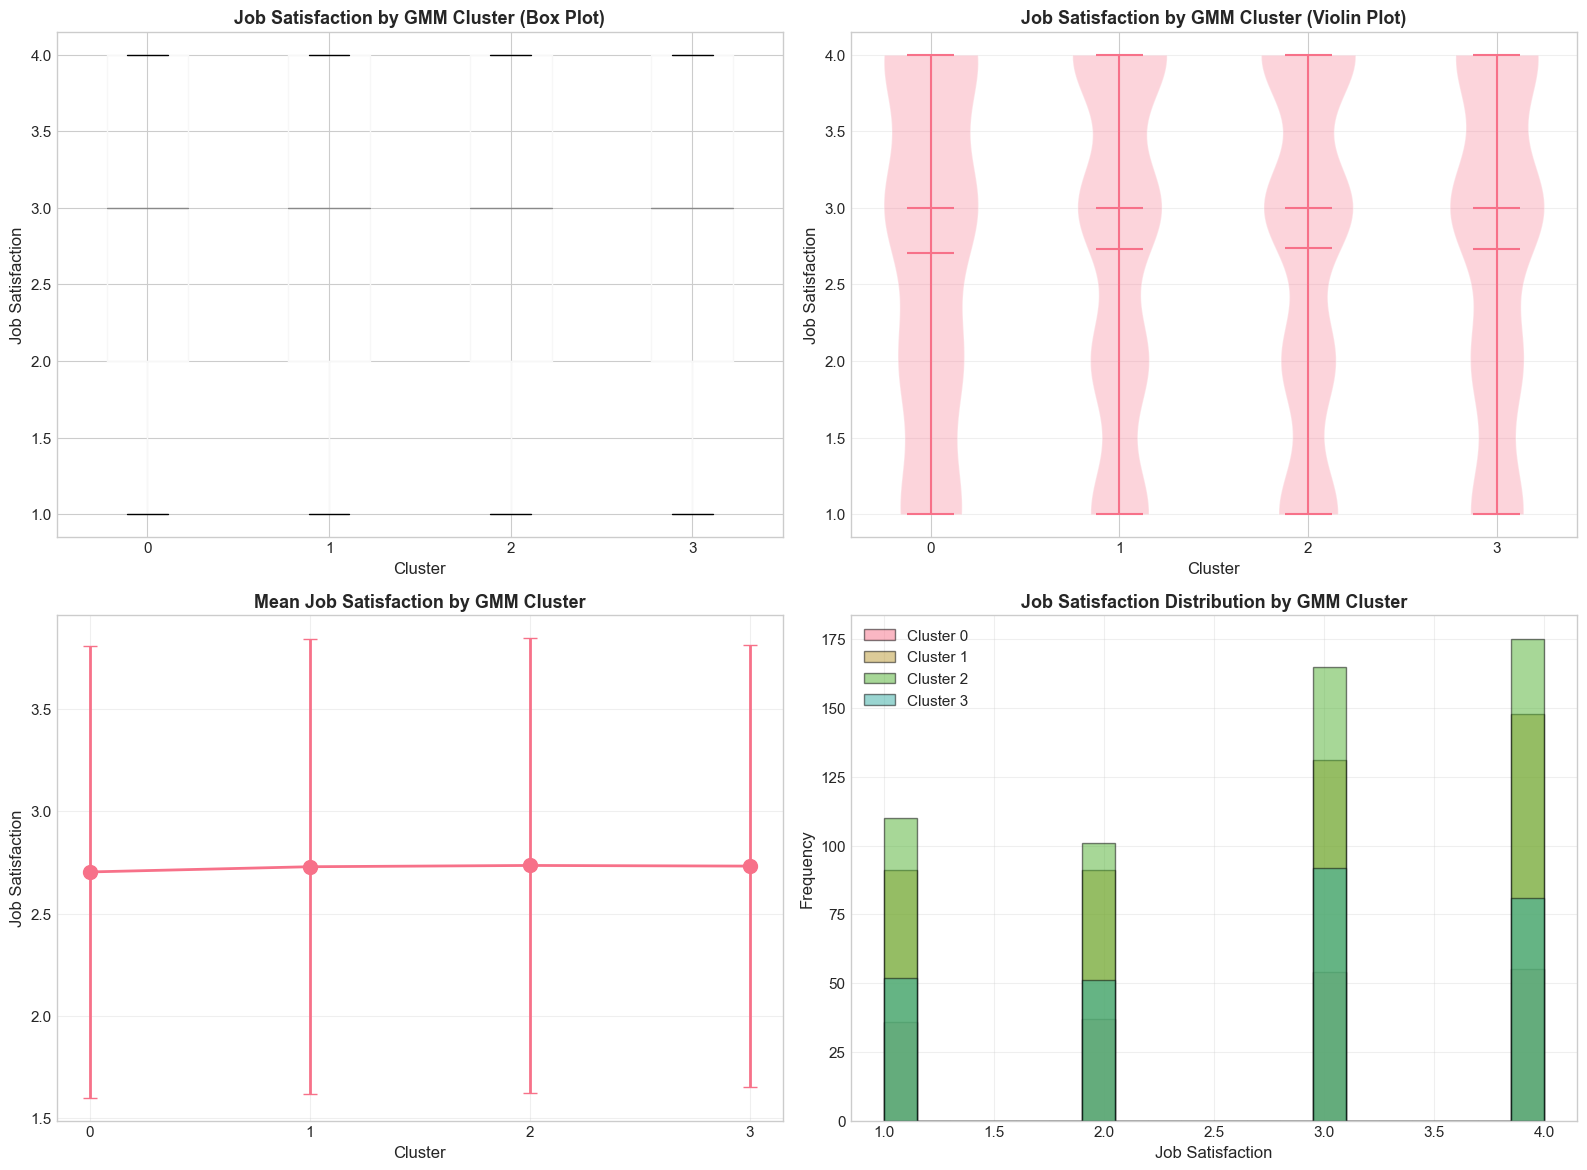


✓ GMM cluster-target analysis saved!


In [10]:
df_gmm_analysis = pd.DataFrame({
    'Cluster': gmm_labels,
    'JobSatisfaction': y
})

# Descriptive statistics
gmm_cluster_stats = df_gmm_analysis.groupby('Cluster')['JobSatisfaction'].describe()
print("\nJob Satisfaction Statistics by GMM Cluster:")
print(gmm_cluster_stats)

# ANOVA test
gmm_clusters_data = [df_gmm_analysis[df_gmm_analysis['Cluster'] == i]['JobSatisfaction'].values
                     for i in range(optimal_k)]
gmm_f_stat, gmm_p_value = stats.f_oneway(*gmm_clusters_data)
print(f"\nANOVA Test (GMM):")
print(f"  F-statistic: {gmm_f_stat:.4f}")
print(f"  P-value: {gmm_p_value:.6f}")
if gmm_p_value < 0.05:
    print("  Result: Significant difference between clusters (p < 0.05)")
else:
    print("  Result: No significant difference between clusters (p >= 0.05)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot
df_gmm_analysis.boxplot(column='JobSatisfaction', by='Cluster', ax=axes[0, 0])
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Job Satisfaction', fontsize=12)
axes[0, 0].set_title('Job Satisfaction by GMM Cluster (Box Plot)',
                     fontsize=13, fontweight='bold')
axes[0, 0].get_figure().suptitle('')

# 2. Violin plot
parts = axes[0, 1].violinplot([df_gmm_analysis[df_gmm_analysis['Cluster'] == i]['JobSatisfaction'].values
                                for i in range(optimal_k)],
                               positions=range(optimal_k),
                               showmeans=True, showmedians=True)
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Job Satisfaction', fontsize=12)
axes[0, 1].set_title('Job Satisfaction by GMM Cluster (Violin Plot)',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(range(optimal_k))
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Mean with error bars
gmm_means = gmm_cluster_stats['mean'].values
gmm_stds = gmm_cluster_stats['std'].values
axes[1, 0].errorbar(range(optimal_k), gmm_means, yerr=gmm_stds,
                    marker='o', markersize=10, linewidth=2, capsize=5)
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Job Satisfaction', fontsize=12)
axes[1, 0].set_title('Mean Job Satisfaction by GMM Cluster',
                     fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(optimal_k))
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution histograms
for i in range(optimal_k):
    cluster_data = df_gmm_analysis[df_gmm_analysis['Cluster'] == i]['JobSatisfaction']
    axes[1, 1].hist(cluster_data, bins=20, alpha=0.5, label=f'Cluster {i}',
                    edgecolor='black')
axes[1, 1].set_xlabel('Job Satisfaction', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Job Satisfaction Distribution by GMM Cluster',
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/clustering/gmm_target_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ GMM cluster-target analysis saved!")

9.K-Means vs GMM Comparison


Metrics Comparison:
           Metric    K-Means       GMM Better
 Silhouette Score   0.102282  0.065045 Higher
   Davies-Bouldin   2.439830  3.210938  Lower
Calinski-Harabasz 104.540701 96.446187 Higher

Winner by Metric:
  Silhouette Score: K-Means (0.1023 > 0.0650)
  Davies-Bouldin: K-Means (2.4398 < 3.2109)
  Calinski-Harabasz: K-Means (104.5407 > 96.4462)


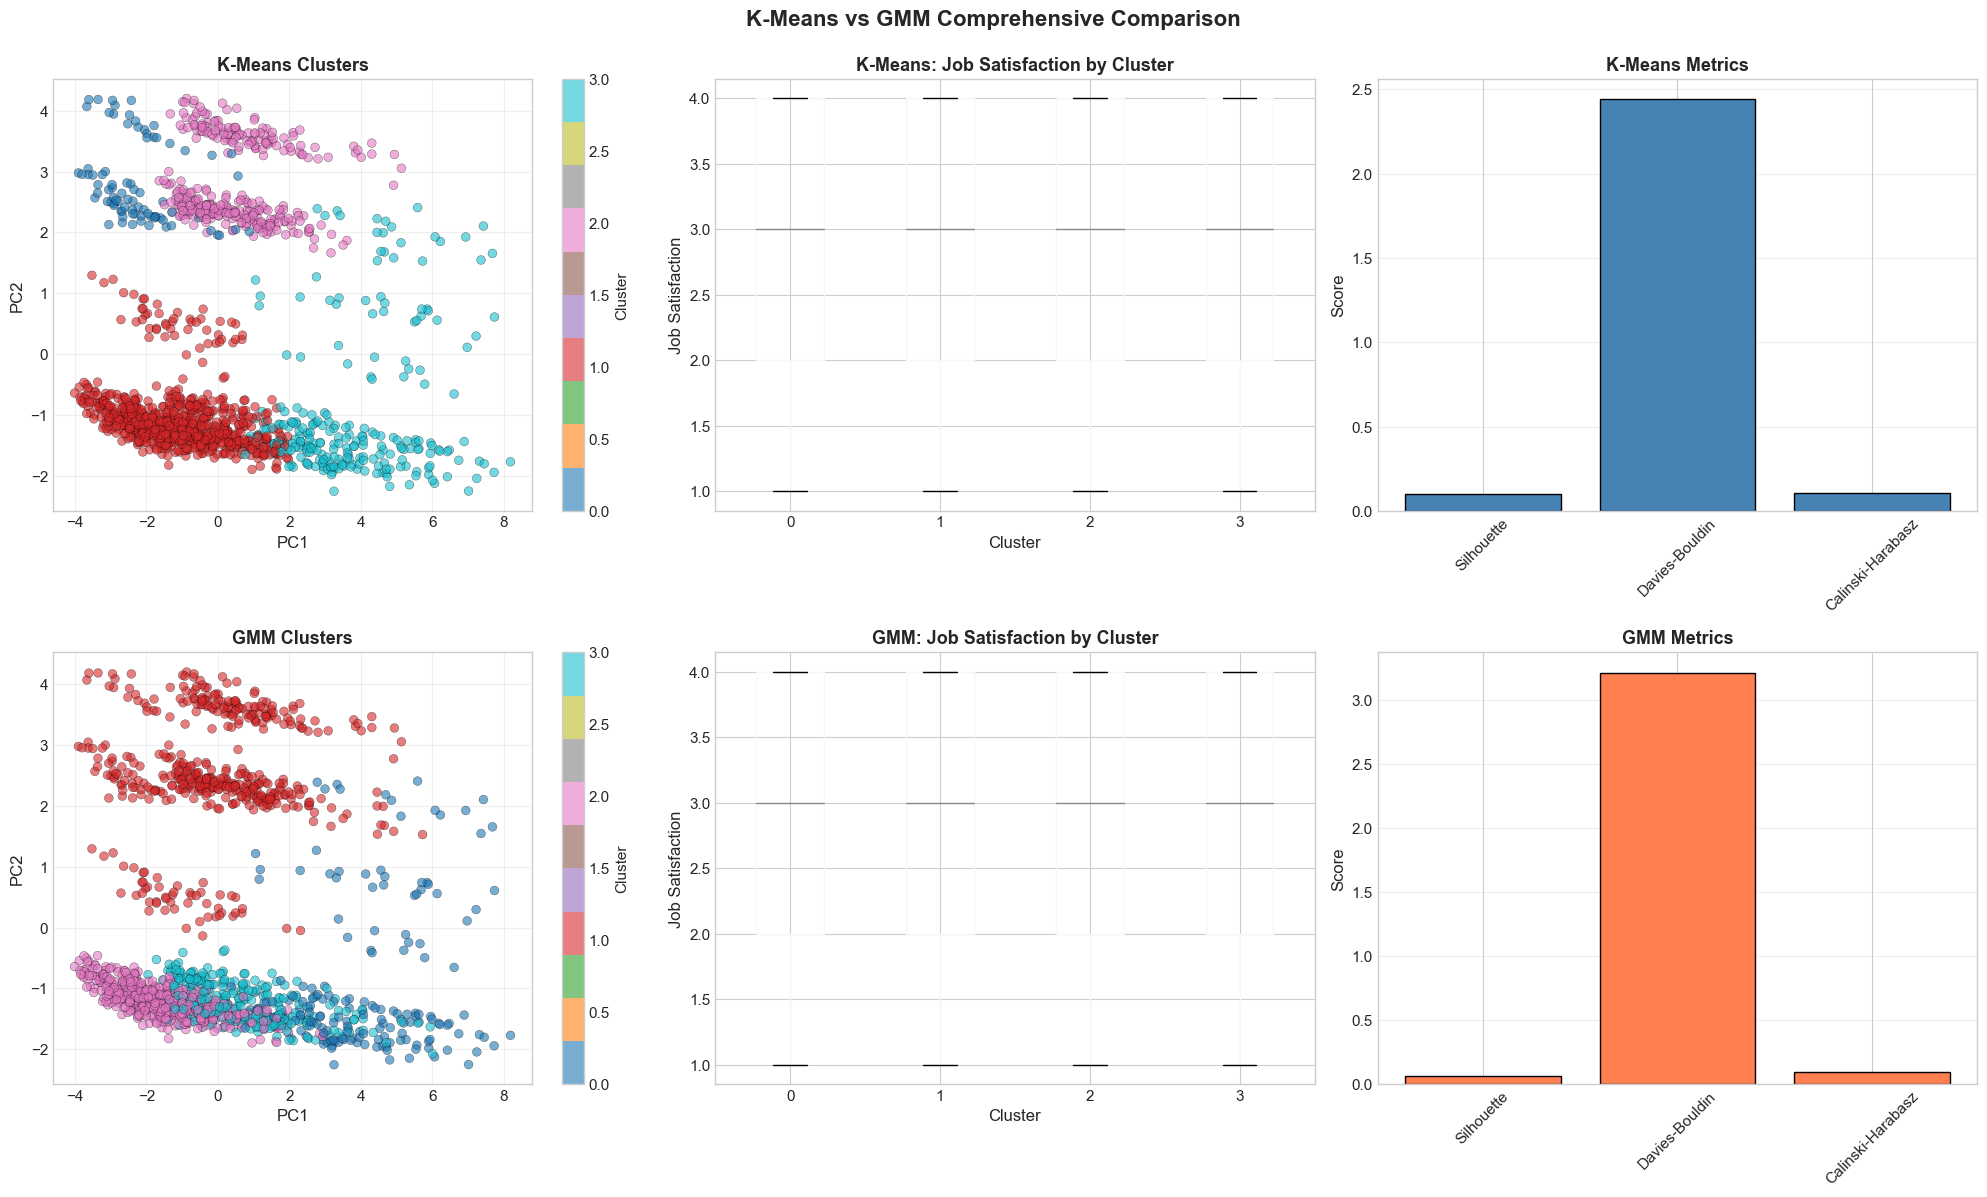


✓ K-Means vs GMM comparison saved!


In [11]:
# Create comparison dataframe
comparison_data = {
    'Metric': ['Silhouette Score', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'K-Means': [kmeans_silhouette, kmeans_davies, kmeans_calinski],
    'GMM': [gmm_silhouette, gmm_davies, gmm_calinski],
    'Better': ['Higher', 'Lower', 'Higher']
}
comparison_df = pd.DataFrame(comparison_data)

print("\nMetrics Comparison:")
print(comparison_df.to_string(index=False))

# Determine winner for each metric
print("\nWinner by Metric:")
if kmeans_silhouette > gmm_silhouette:
    print(f"  Silhouette Score: K-Means ({kmeans_silhouette:.4f} > {gmm_silhouette:.4f})")
else:
    print(f"  Silhouette Score: GMM ({gmm_silhouette:.4f} > {kmeans_silhouette:.4f})")

if kmeans_davies < gmm_davies:
    print(f"  Davies-Bouldin: K-Means ({kmeans_davies:.4f} < {gmm_davies:.4f})")
else:
    print(f"  Davies-Bouldin: GMM ({gmm_davies:.4f} < {kmeans_davies:.4f})")

if kmeans_calinski > gmm_calinski:
    print(f"  Calinski-Harabasz: K-Means ({kmeans_calinski:.4f} > {gmm_calinski:.4f})")
else:
    print(f"  Calinski-Harabasz: GMM ({gmm_calinski:.4f} > {kmeans_calinski:.4f})")

# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: K-Means
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=kmeans_labels, cmap='tab10',
                               alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
axes[0, 0].set_xlabel('PC1', fontsize=12)
axes[0, 0].set_ylabel('PC2', fontsize=12)
axes[0, 0].set_title('K-Means Clusters', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

df_analysis.boxplot(column='JobSatisfaction', by='Cluster', ax=axes[0, 1])
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Job Satisfaction', fontsize=12)
axes[0, 1].set_title('K-Means: Job Satisfaction by Cluster',
                     fontsize=13, fontweight='bold')
axes[0, 1].get_figure().suptitle('')

# Metrics bar chart for K-Means
metrics_kmeans = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']
values_kmeans = [kmeans_silhouette, kmeans_davies, kmeans_calinski/1000]  # Scale Calinski
axes[0, 2].bar(metrics_kmeans, values_kmeans, color='steelblue', edgecolor='black')
axes[0, 2].set_ylabel('Score', fontsize=12)
axes[0, 2].set_title('K-Means Metrics', fontsize=13, fontweight='bold')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Row 2: GMM
scatter2 = axes[1, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                               c=gmm_labels, cmap='tab10',
                               alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
axes[1, 0].set_xlabel('PC1', fontsize=12)
axes[1, 0].set_ylabel('PC2', fontsize=12)
axes[1, 0].set_title('GMM Clusters', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1, 0], label='Cluster')

df_gmm_analysis.boxplot(column='JobSatisfaction', by='Cluster', ax=axes[1, 1])
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Job Satisfaction', fontsize=12)
axes[1, 1].set_title('GMM: Job Satisfaction by Cluster',
                     fontsize=13, fontweight='bold')
axes[1, 1].get_figure().suptitle('')

# Metrics bar chart for GMM
values_gmm = [gmm_silhouette, gmm_davies, gmm_calinski/1000]  # Scale Calinski
axes[1, 2].bar(metrics_kmeans, values_gmm, color='coral', edgecolor='black')
axes[1, 2].set_ylabel('Score', fontsize=12)
axes[1, 2].set_title('GMM Metrics', fontsize=13, fontweight='bold')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.suptitle('K-Means vs GMM Comprehensive Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/clustering/kmeans_vs_gmm_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ K-Means vs GMM comparison saved!")

10.Agreement Between K-Means and GMM


Agreement Metrics:
  Adjusted Rand Index (ARI): 0.5133
  Normalized Mutual Information (NMI): 0.6024

Interpretation:
  ARI = 1: Perfect agreement
  ARI = 0: Random labeling
  Our ARI = 0.5133: Moderate agreement


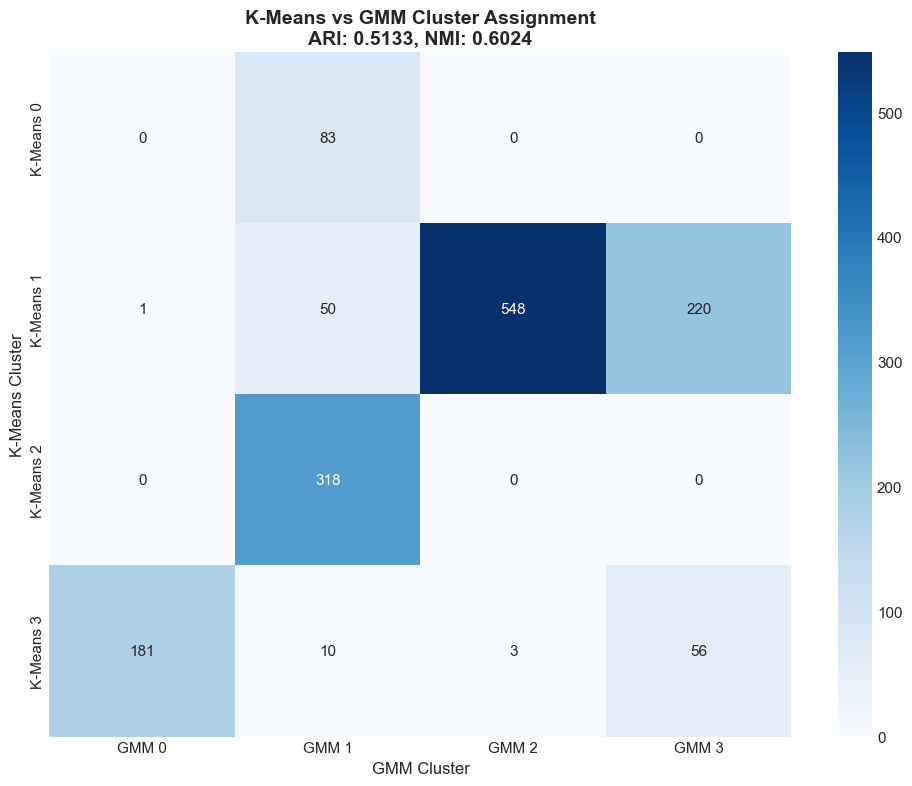


✓ Agreement analysis saved!


In [12]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Compute agreement metrics
ari = adjusted_rand_score(kmeans_labels, gmm_labels)
nmi = normalized_mutual_info_score(kmeans_labels, gmm_labels)

print(f"\nAgreement Metrics:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Normalized Mutual Information (NMI): {nmi:.4f}")

print("\nInterpretation:")
print(f"  ARI = 1: Perfect agreement")
print(f"  ARI = 0: Random labeling")
print(f"  Our ARI = {ari:.4f}: {'High' if ari > 0.7 else 'Moderate' if ari > 0.4 else 'Low'} agreement")

# Confusion matrix between K-Means and GMM
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(kmeans_labels, gmm_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'GMM {i}' for i in range(optimal_k)],
            yticklabels=[f'K-Means {i}' for i in range(optimal_k)])
plt.xlabel('GMM Cluster', fontsize=12)
plt.ylabel('K-Means Cluster', fontsize=12)
plt.title(f'K-Means vs GMM Cluster Assignment\nARI: {ari:.4f}, NMI: {nmi:.4f}',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/clustering/clustering_agreement.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Agreement analysis saved!")

11.DBSCAN Clustering (Optional)


Testing different eps values...

eps = 0.5:
  Number of clusters: 0
  Noise points: 1470 (100.0%)

eps = 1.0:
  Number of clusters: 0
  Noise points: 1470 (100.0%)

eps = 1.5:
  Number of clusters: 0
  Noise points: 1470 (100.0%)

eps = 2.0:
  Number of clusters: 0
  Noise points: 1470 (100.0%)


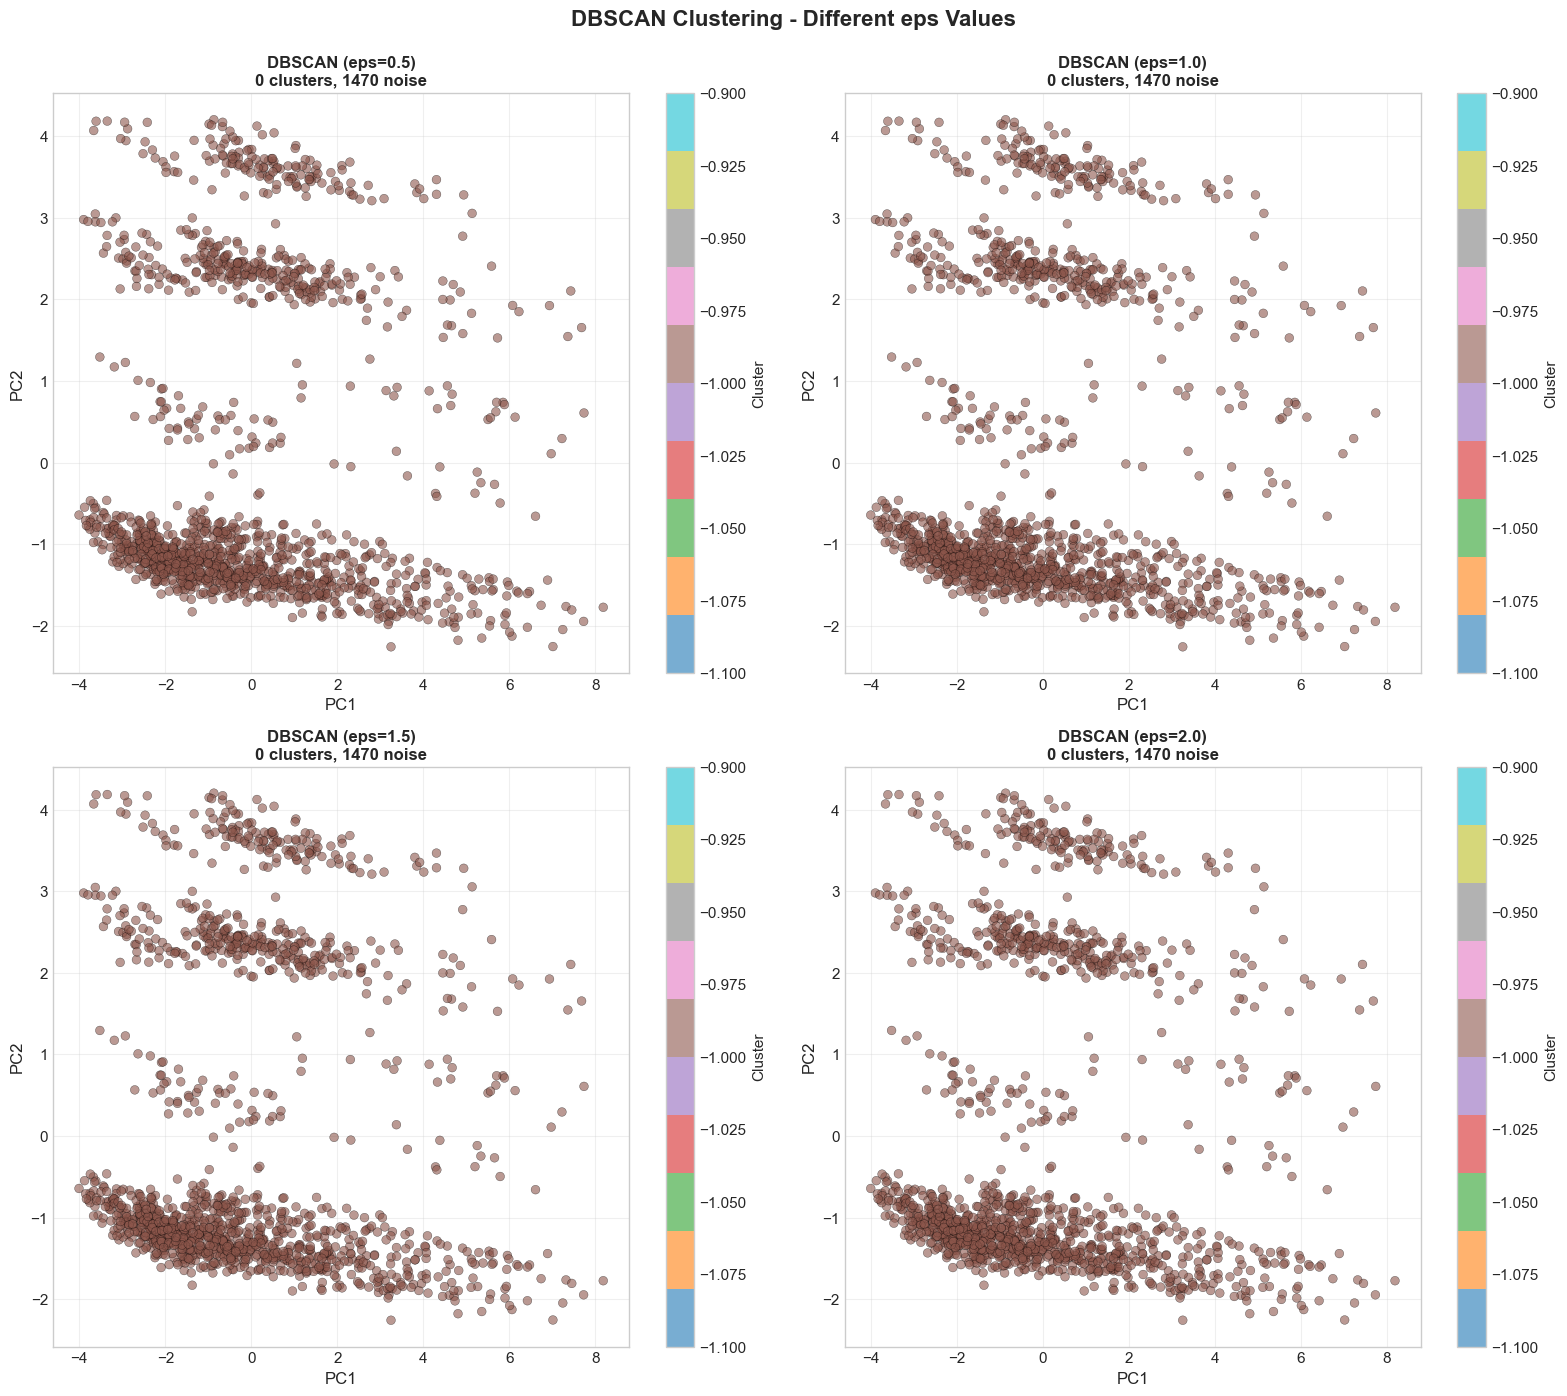


✓ DBSCAN analysis saved!


In [13]:
# Test different eps values
eps_values = [0.5, 1.0, 1.5, 2.0]
dbscan_results = {}

print("\nTesting different eps values...")
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)

    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    dbscan_results[eps] = {
        'labels': dbscan_labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise
    }

    print(f"\neps = {eps}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Noise points: {n_noise} ({100*n_noise/len(dbscan_labels):.1f}%)")

    if n_clusters > 1:
        valid_mask = dbscan_labels != -1
        if valid_mask.sum() > 0:
            sil = silhouette_score(X[valid_mask], dbscan_labels[valid_mask])
            print(f"  Silhouette Score: {sil:.4f}")
            dbscan_results[eps]['silhouette'] = sil

# Visualize DBSCAN results
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, eps in enumerate(eps_values):
    labels = dbscan_results[eps]['labels']

    # Create color map (noise points in black)
    colors = labels.copy().astype(float)
    colors[colors == -1] = -1

    scatter = axes[idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                                c=colors, cmap='tab10',
                                alpha=0.6, s=40, edgecolor='k', linewidth=0.3)
    axes[idx].set_xlabel('PC1', fontsize=12)
    axes[idx].set_ylabel('PC2', fontsize=12)
    axes[idx].set_title(f'DBSCAN (eps={eps})\n{dbscan_results[eps]["n_clusters"]} clusters, {dbscan_results[eps]["n_noise"]} noise',
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')

plt.suptitle('DBSCAN Clustering - Different eps Values',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/clustering/dbscan_results.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ DBSCAN analysis saved!")

12.Export Results

In [14]:
# Save cluster labels
clustering_results = pd.DataFrame({
    'KMeans_Cluster': kmeans_labels,
    'GMM_Cluster': gmm_labels,
    'GMM_Probability': max_probs,
    'JobSatisfaction': y
})

clustering_results.to_csv('../results/metrics/clustering_labels.csv', index=False)
print("✓ Saved: clustering_labels.csv")

# Save metrics summary
metrics_summary = pd.DataFrame({
    'Method': ['K-Means', 'GMM'],
    'Silhouette_Score': [kmeans_silhouette, gmm_silhouette],
    'Davies_Bouldin_Index': [kmeans_davies, gmm_davies],
    'Calinski_Harabasz_Score': [kmeans_calinski, gmm_calinski]
})
metrics_summary.to_csv('../results/metrics/clustering_metrics.csv', index=False)
print("✓ Saved: clustering_metrics.csv")

# Save cluster statistics
cluster_stats.to_csv('../results/metrics/kmeans_cluster_stats.csv')
gmm_cluster_stats.to_csv('../results/metrics/gmm_cluster_stats.csv')
print("✓ Saved: cluster statistics")

✓ Saved: clustering_labels.csv
✓ Saved: clustering_metrics.csv
✓ Saved: cluster statistics
